# word2vec on the stanford encyclopedia


In [1]:

import pandas as pd
import numpy as np
from random import randint
import datetime


%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython

from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn import datasets
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_files
from scipy import sparse
import gensim
import re
import nltk
from nltk.corpus import stopwords  

import os
from fnmatch import fnmatch



C:\Users\user\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Load the textual data:

In [2]:
# texts = load_files("./trainingdata", 
#     description=None, #categories=categories, 
#     load_content=True, encoding='utf-8', shuffle=False)#, random_state=42)


In [3]:
# data = " ".join(texts.data)
# #

In [2]:
TRAINING_DATA_FOLDER = './trainingdata'

def get_all_training_files_from_dir(root, pattern='*.txt'):
    all_files = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                 all_files.append(os.path.join(path, name))
                
    return all_files

# get all files and make sure it all makes sense
all_sep_files = get_all_training_files_from_dir(TRAINING_DATA_FOLDER)
print(all_sep_files[:3], len(all_sep_files))

['./trainingdata\\17th and 18th Century Theories of Emotions\\17th and 18th Century Theories of Emotions.txt', './trainingdata\\18th Century British Aesthetics\\18th Century British Aesthetics.txt', './trainingdata\\18th Century French Aesthetics\\18th Century French Aesthetics.txt'] 1403


In [3]:
texts = []
for sep_file in all_sep_files:
    with open(sep_file, encoding='utf-8') as f_in:
        data = f_in.read().replace('\n', '')
        # just split on . and tokenize with gensim
        texts.append(gensim.utils.simple_preprocess(data))
# debug
print(texts[0][:10], texts[10][10:20])

['early', 'modern', 'philosophy', 'in', 'europe', 'and', 'great', 'britain', 'is', 'awash'] ['our', 'abilities', 'appear', 'to', 'be', 'indispensable', 'some', 'abilities', 'are', 'so']


In [4]:
model = gensim.models.Word2Vec(texts, min_count=5)#, size=200, workers=10, window=5, iter=50)

Get a list of philosophers names from wikipedia & clean it:

In [109]:
from bs4 import BeautifulSoup
import requests


urls = ['https://en.wikipedia.org/wiki/List_of_philosophers_(A%E2%80%93C)', 'https://en.wikipedia.org/wiki/List_of_philosophers_(D%E2%80%93H)',
       'https://en.wikipedia.org/wiki/List_of_philosophers_(I%E2%80%93Q)','https://en.wikipedia.org/wiki/List_of_philosophers_(R%E2%80%93Z)']
philosophers = []
for url in urls:
    print(url)
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")
    pagetext = soup.select("ul > li > a") #soup.findAll('a')#, attrs={'class': 'reference'})


    for a in pagetext:
        text = a.get_text()
        if text == 'Lists of philosophers':
            break
        philosophers.append(text)
        

# print(philosophers)

https://en.wikipedia.org/wiki/List_of_philosophers_(A%E2%80%93C)
https://en.wikipedia.org/wiki/List_of_philosophers_(D%E2%80%93H)
https://en.wikipedia.org/wiki/List_of_philosophers_(I%E2%80%93Q)
https://en.wikipedia.org/wiki/List_of_philosophers_(R%E2%80%93Z)
['Article', 'Category', 'Glossary', 'Outline', 'Portal', 'Adi Shankara', 'Nicola Abbagnano', 'Muhammad Abduh', 'Peter Abelard', 'Abhinavagupta', 'Isaac ben Judah Abravanel', 'Judah ben Isaac Abravanel', 'Marilyn McCord Adams', 'Robert Adams', 'Joseph Addison', 'Adelard of Bath', 'Alfred Adler', 'Theodor Adorno', 'Aenesidemus', 'Jamal al-Din al-Afghani', 'Rodolphus Agricola', 'Agrippa the Sceptic', 'Heinrich Cornelius Agrippa', "Pierre d'Ailly", 'Kazimierz Ajdukiewicz', 'Hans Albert', 'Albert of Saxony', 'Albertus Magnus', 'Joseph Albo', 'Alcinous', 'Alcmaeon of Croton', 'Virgil Aldrich', 'Yohanan ben Isaac Alemanno', 'Alexander of Aphrodisias', 'Alexander of Hales', 'Samuel Alexander', 'Dante Alighieri', 'Antonio Aliotta', 'Archib

In [123]:
philosophers_new = []
bs = ['Article', 'Category', 'Glossary', 'Outline', 'Portal']
for x in philosophers:
    y = x.split(' ')
    if not set(bs).isdisjoint(y):
        pass
    else:
        if 'of' in y: 
            break
            #philosophers_new.append(y[0])
        else:
            philosophers_new.append(y[-1])

In [164]:
philosophers = []
for x in philosophers_new:
    if x.lower() in model.wv.vocab:
        philosophers.append(x.lower())
philosophers = list(set(philosophers))
print('There are ' + str(len(philosophers)) + ' philosophers in our list.')

There are 1022 philosophers in our list.


Build a similarity-matrix:

In [132]:
philosophers_similarities = []
for x in philosophers:
    line = []
    for y in philosophers:
        line.append(model.similarity(x,y))
    philosophers_similarities.append(line)




C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


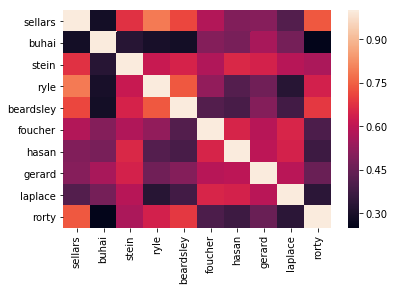

In [201]:
# Build a heatmap of some random similarity-scores

idx = np.random.randint(len(philosophers), size=10)
philosophers_sample = np.array(philosophers_similarities)[idx,:][:,idx]
index = [philosophers[i] for i in idx]

df = pd.DataFrame(philosophers_sample, index=index, columns=index)
ax = sns.heatmap(df)
ax

In [226]:
import umap
from sklearn import manifold, datasets


x = np.array(philosophers_similarities)
# U = model[model.wv.vocab]
U = model[philosophers]


# embedding = manifold.TSNE(n_components=2, init='random',
#                          random_state=0, metric='precomputed'
#                           ,perplexity=30).fit_transform(U)


embedding = umap.UMAP(n_neighbors=5,#small => local, large => global: 5-50
                      min_dist=0.01, metric='euclidean'
                      ).fit_transform(U)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


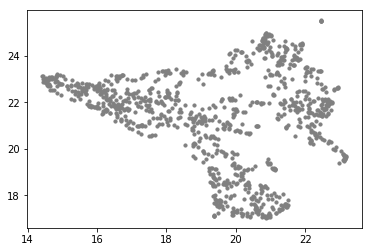

In [228]:
embedding_df = pd.DataFrame(embedding)
embedding_df.columns = ['x','y']
plt.scatter(embedding_df['x'], embedding_df['y'], color='grey',s=10)
embedding_df['label'] = philosophers# list(model.wv.vocab.keys())

In [229]:
from bokeh.plotting import figure, show, output_notebook#,  output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()
# output_file('embedded_bigram_timeseries_bokeh.html')

#TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
p = figure(title='Positions of philosophers',
    plot_width=900,
    plot_height=600,
    tools=('pan, wheel_zoom, reset','lasso_select'))

p.add_tools(HoverTool(tooltips="""

<div>
@label
</div>
"""))

p.scatter(x='x', y='y',source=embedding_df, fill_color='#483D8B', fill_alpha=0.6,size=5, line_color=None)

show(p)


Loading BokehJS ...